# Walmart Triptype Classification

    
    Team SS60: 이수정 백형렬 노승환

# <center> 프로세스 </center>
# 0. 환경설정
# 1. 모델의 성능
# 2. 변수설명
# 3. 전처리 및 EDA
# 4. lightgbm을 사용한 분류
# 5. kaggle에 제출
# 6. 한계점 및 보완방향

# <center>0.환경설정</center>

In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from scipy.sparse import csr_matrix
import lightgbm
import warnings
import numpy as np
import pandas as pd
from IPython.display import Markdown
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# <center> 1. 모델의 성능</center>

## 1-1. Accuracy

In [72]:
# 성능을 저장해놓고 보여주기 위한 코드입니다. 코드를 실행할 땐 전처리 과정을 모두 실행해줘야만 코드가 돌아갑니다.
accuracy = 100 * (1 - (sum(int(y_pred[i]) != y_test[i]
                           for i in range(len(y_test))) / float(len(y_test))))
print("TripType Accuracy = %.2f%%" % accuracy)

TripType Accuracy = 77.37%


## 1-2. Classification_report

In [73]:
# 성능을 저장해놓고 보여주기 위한 코드입니다. 코드를 실행할 땐 전처리 과정을 모두 실행해줘야만 코드가 돌아갑니다.
print(classification_report(label_enc.inverse_transform(y_test), label_enc.inverse_transform(y_pred)))

              precision    recall  f1-score   support

           3       0.94      0.98      0.96       931
           4       0.81      0.67      0.73        87
           5       0.85      0.87      0.86      1167
           6       0.82      0.85      0.84       309
           7       0.79      0.80      0.80      1494
           8       0.88      0.90      0.89      3017
           9       0.78      0.86      0.82      2307
          12       0.64      0.37      0.47        62
          14       0.00      0.00      0.00         2
          15       0.63      0.59      0.61       237
          18       0.59      0.50      0.54       131
          19       0.73      0.64      0.68        80
          20       0.76      0.63      0.69       173
          21       0.72      0.66      0.69       158
          22       0.67      0.70      0.68       207
          23       0.75      0.63      0.68        43
          24       0.71      0.70      0.71       652
          25       0.74    

## 하위 4개의 class를 제외하고 precision과 recall이 60퍼센트 이상임을 확인할 수 있습니다.

# <center>2.데이터 및 변수 설명</center>

![score](walmart.png)

## walmart triptype classification : [walmart triptype classification](https://www.kaggle.com/c/walmart-recruiting-trip-type-classification)

# 약 3년전 종료된 kaggle competition으로, 월마트측에서 자체적으로 분류한 38가지의 고객 특성을 고객이 구매한 전산 데이터만을 사용해 고객 특성을 분류해보는것이 목적입니다.

## - 평가방식 : Multi-class log 

## <center>$-\frac{1}{N}\sum_{i=1}^N\sum_{j=1}^My_{ij}\log(p_{ij}),$</center>

## - 분류할 타겟 : 고객의 특성 (38종류)

In [3]:
train.shape, test.shape

((647054, 7), (653646, 6))

In [4]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


# 2-1. `TripType`  [target]
- 이번 분석에서의 Target값

- 고객의 구매 활동을 나타내는 카테고리컬 식별값입니다. 
- 다른 변수들을 분석해 38가지 중에 하나로 분류해야 합니다. 
- TripType '999' 는 총 구매한 아이템의 수가 음수, 즉 최종 구매 활동이 반환 인 구매자를 의미합니다.

In [5]:
print(train.TripType.unique())
print("{}가지 ID가 있습니다.".format(len(train.TripType.unique())))

[999  30  26   8  35  41  21   6  42   7   9  39  25  38  15  36  20  37
  32  40   5   3   4  24  33  43  31  27  34  18  29  44  19  23  22  28
  14  12]
38가지 ID가 있습니다.


## TripType별 카운트는 다음과 같습니다.

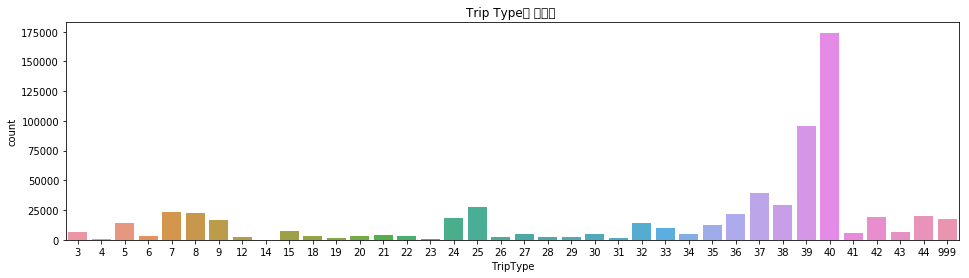

In [6]:
plt.figure(figsize=(16, 4))
sns.countplot(x="TripType", data=train)
plt.title("Trip Type별 카운트 ")
plt.show()

## TripType 999는 반품하러 온 사람들을 의미합니다.

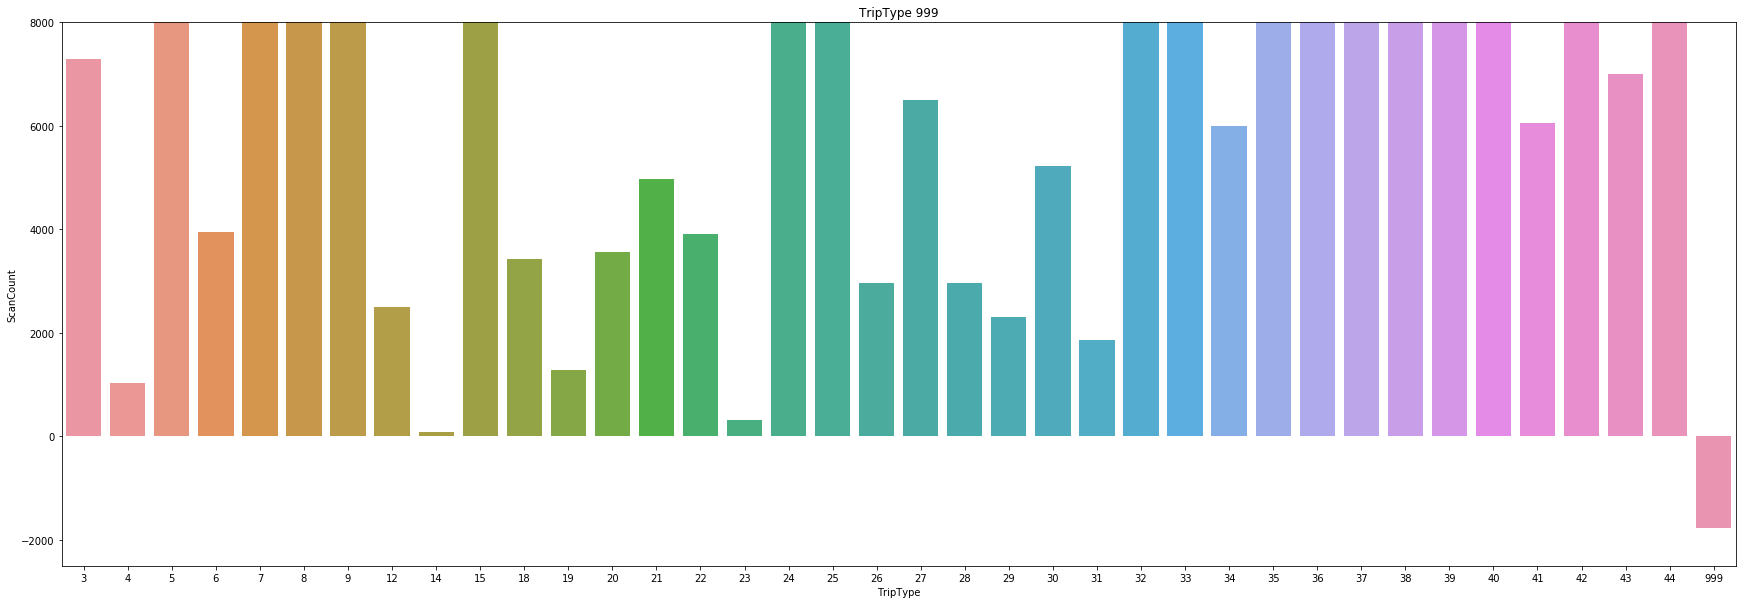

In [7]:
train_tt_sc = train.groupby('TripType',as_index=False)['ScanCount'].sum()

plt.figure(figsize=(30,10))
sns.barplot(train_tt_sc['TripType'].astype('int') , train_tt_sc['ScanCount'])
plt.ylim(-2500,8000)
plt.title("TripType 999")
plt.show()

# 2.2 `VisitNumber`
- 단일 고객의 단일 구매 활동을 나타내는 값
- 95674가지 값을 가집니다.

In [8]:
len(train.VisitNumber.unique())

95674

In [9]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


### 최종적으로 예측할 TripType은 VisitNumber별로 예측합니다. 같은 VisitNumber(손님)은 같은 TripType을 가짐을 알 수 있습니다.

## 7번 고객은 각각 다른 물품을 하나씩, 총 2개씩 구매했습니다.

# 2.3 `Weekday` 
- 거래가 일어난 요일을 나타냅니다.

In [10]:
print(train.Weekday.unique())

['Friday' 'Saturday' 'Sunday' 'Monday' 'Tuesday' 'Wednesday' 'Thursday']


# 2.4 `ScanCount`
- 해당 상품을 한번에 몇 개 샀는지를 나타냅니다.
- 반품했을 경우 음수값으로 표시합니다.

In [11]:
print(train.ScanCount.unique())
print(train.ScanCount.describe())

[ -1   1   2   3   5   6   4  14  -2   9   7  10   8  -3  -5  11  16  -4
  13  15  30  -6  12  20 -12  19  46  23  -7  22  25  24  31  -9  51  17
  18  71 -10]
count    647054.000000
mean          1.108878
std           0.700776
min         -12.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          71.000000
Name: ScanCount, dtype: float64


# 2.5 `DepartmentDescription` 
- 상품 대분류
- 이 기준에 따르면 상품들은 68가지로 분류됩니다.

In [12]:
len(train["DepartmentDescription"].unique().tolist())
train = train.replace('MENSWEAR', 'MENS WEAR')
test = test.replace('MENSWEAR', 'MENS WEAR')

In [13]:
print(len(train.DepartmentDescription.unique()))
print(train.DepartmentDescription.unique())

68
['FINANCIAL SERVICES' 'SHOES' 'PERSONAL CARE' 'PAINT AND ACCESSORIES'
 'DSD GROCERY' 'MEAT - FRESH & FROZEN' 'DAIRY' 'PETS AND SUPPLIES'
 'HOUSEHOLD CHEMICALS/SUPP' nan 'IMPULSE MERCHANDISE' 'PRODUCE'
 'CANDY, TOBACCO, COOKIES' 'GROCERY DRY GOODS' 'BOYS WEAR'
 'FABRICS AND CRAFTS' 'JEWELRY AND SUNGLASSES' 'MENS WEAR' 'ACCESSORIES'
 'HOME MANAGEMENT' 'FROZEN FOODS' 'SERVICE DELI'
 'INFANT CONSUMABLE HARDLINES' 'PRE PACKED DELI' 'COOK AND DINE'
 'PHARMACY OTC' 'LADIESWEAR' 'COMM BREAD' 'BAKERY' 'HOUSEHOLD PAPER GOODS'
 'CELEBRATION' 'HARDWARE' 'BEAUTY' 'AUTOMOTIVE' 'BOOKS AND MAGAZINES'
 'SEAFOOD' 'OFFICE SUPPLIES' 'LAWN AND GARDEN' 'SHEER HOSIERY' 'WIRELESS'
 'BEDDING' 'BATH AND SHOWER' 'HORTICULTURE AND ACCESS' 'HOME DECOR' 'TOYS'
 'INFANT APPAREL' 'LADIES SOCKS' 'PLUS AND MATERNITY' 'ELECTRONICS'
 'GIRLS WEAR, 4-6X  AND 7-14' 'BRAS & SHAPEWEAR' 'LIQUOR,WINE,BEER'
 'SLEEPWEAR/FOUNDATIONS' 'CAMERAS AND SUPPLIES' 'SPORTING GOODS'
 'PLAYERS AND ELECTRONICS' 'PHARMACY RX' 'OPTICAL - FRA

In [14]:
train[train.DepartmentDescription == 'SHOES'].count()

TripType                 6099
VisitNumber              6099
Weekday                  6099
Upc                      6099
ScanCount                6099
DepartmentDescription    6099
FinelineNumber           6099
dtype: int64

# 2.6 `FinelineNumber` 
- 월마트가 자체적으로 사용하는 세분화된 상품 분류 코드
- 이 기준에 따르면 상품들은 5196가지로 분류됩니다.

In [15]:
print(len(train.FinelineNumber.unique()))
print(train.FinelineNumber.unique())

5196
[1000. 8931. 4504. ... 8257. 4314. 7130.]


# 2.7 `Upc`
- Universal Product Code. 구매한 제품의 고유값
- 97715개 상품이 팔렸습니다.

## UPC란 우리가 흔히 알고있는 바코드를 의미합니다. full UPC는 12자리입니다.


## train 데이터셋에서 UPC의 길이가 다 다름을 알 수 있습니다. UPC의 앞 6자리는 제품을 생산한 회사를 의미하므로, 길이가 6 미만인 것들은 월마트에서 자체생산한 상품임을 알 수 있습니다.(치킨 등 음식류) 

In [16]:
len(train.Upc.unique())

97715

In [17]:
print(train.Upc.min().astype(str)[:-2])
print(train.Upc.max().astype(str)[:-2])

834
978970666419


# <center>3.전처리 및 EDA</center>

# 3-1. `TripType` 별 많이 나오는 상품 분류
- 타입별로 어떤 물건을 사러 온 손님인지 뚜렷하게 구분이 되는 경우가 많습니다.

In [18]:
description = {
    0: "타입3은 Financial Services가 주를 이룹니다.",
    1: "타입4는 Pharmacy OTC가 가장 많이 나옵니다.",
    2: "타입5도 Pharmacy OTC가 가장 많이 나오는데 좀 더 살펴볼 필요가 있습니다.",
    3: "타입6은 음주자 타입인듯 합니다. 주류가 가장 많고, 안주꺼리인 캔디, 쿠키, 담배 등도 있습니다.",
    4: "타입7은 '배고픈 사람' 타입인듯 합니다. 조리 식품, 식료품, 냉동식품 등이 있습니다.",
    5: "타입8은 일반 가정에서 필요한 물건을 ('장보러') 사러 온 타입인듯 합니다. 식료품이 가장 많이 나타나고, Personal Care가 뒤를 잇습니다.",
    6: "타입9은 남성 고객군인듯 합니다. 남성복과 자동차용품, 사무용품 등을 많이 구매했습니다.",
    7: "타입12는 뚜렷한 특성을 찾기 어렵습니다.",
    8: "타입14는 소소한 취미 타입인듯 합니다. 직물, 수공예품, 애완용품, 게임 등을 구매했습니다.",
    9: "타입15는 파티 타입인듯 합니다. Celebration이 주를 이룹니다.",
    10: "타입18은 장난감 타입입니다. Toys가 가장 많이 보입니다",
    11: "타입19는 전자기기를 사러 온 고객인듯 합니다. Electronics가 가장 많고 나머지는 미미합니다.",
    12: "타입20은 자동차용품을 사러 온 고객인듯 합니다. Automotive가 가장 많고 나머지는 미미합니다.",
    13: "타입21은 잘 알아차리기 어렵습니다. Fabrics and Crafts와 사무용품이 비슷하게 많습니다.",
    14: "타입22는 게이머 고객인듯 합니다. Electronics가 가장 많고 Media and Gaming도 많습니다.",
    15: "타입23은 Players and Electronics와 Media and Gaming 순으로 많습니다. 타입 22와 비교해 볼 필요가 있습니다.",
    16: "타입24는 집순이형 타입입니다. 요리, 집안 관리, 세면용품, 홈 데코 등이 있습니다.", 
    17: "타입25는 가족들 옷을 사러온 타입입니다. 남성복, 여성복, 아이들 옷 등이 주를 이룹니다.",
    18: "타입26은 철물점 타입입니다. Hardware가 가장 많고 페인트와 장식품 등이 있습니다.",
    19: "타입27은 정원관리형 타입입니다. Lawn and Garden과 Horticulture and Access가 많습니다.",
    20: "타입28은 스포츠 타입입니다. 스포츠용품 구매가 가장 많습니다.", 
    21: "타입29는 장난감 타입입니다. Toys, Sporting Goods 순으로 많습니다.",
    22: "타입30은 신발 사러 온 사람들입니다. Shoes가 가장 많습니다.",
    23: "타입31은 통신 관련 소비자군입니다. Wireless가 대부분입니다.",
    24: "타입32는 아기용품을 구매하는 타입입니다.", 
    25: "타입33은 집관리형입니다. Household Chemical Supply가 많습니다.",
    26: "타입34는 애완용품형입니다. Pets and supplies가 많습니다.",
    27: "타입35는 DSD 타입입니다. DSD(Direct Store delivery)란 점포 직접 납품의 약자로, 공급업체가 상품을 유통업체의 물류센터를 경유하지 않고 점포로 직접 납품하는 형태를 말합니다.",
    28: "타입36은 피부 미용 타입입니다. Personal Care, Beauty가 많습니다.",
    29: "타입37은 채소 등 농산물 타입입니다. Produce가 가장 많습니다.",
    30: "타입38은 유제품 타입입니다. Dairy가 가장 많습니다.", 
    31: "타입39는 DSD Grocery, Grocery Dry Goods가 가장 많습니다.",
    32: "타입40은 곡류 타입입니다. Grocery Dry Goods 위주입니다.", 
    33: "타입41은 뚜렷한 특징을 찾기 어렵습니다.", 
    34: "타입42는 충동구매 타입인듯 합니다. Impulse Merchandise 구매가 가장 많습니다.", 
    35: "타입43도 뚜렷한 특징을 찾기 어렵습니다. Personal Care, DSD Grocery 등이 낮은 빈도로 있습니다", 
    36: "타입44는 Personal Care가 가장 많습니다.", 
    37: "타입999는 Financial Service가 주류를 이룹니다. 위에서 봤듯 반품을 위한 방문이며, 반품의 경우 Financial Service로 분류되는듯 합니다. 반품을 하면서도 이것저것 구매한다고 추측해볼 수 있습니다."
}

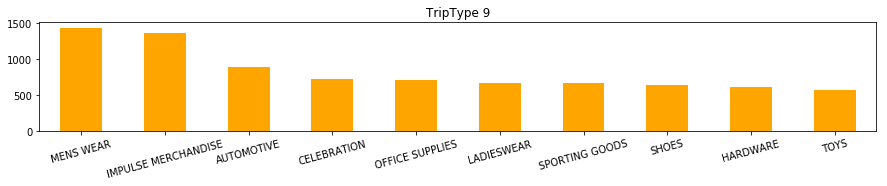

타입9은 남성 고객군인듯 합니다. 남성복과 자동차용품, 사무용품 등을 많이 구매했습니다.
 


In [19]:
triptypelist = sorted(list(train['TripType'].unique()))

type_6 = train[train.TripType == triptypelist[6]]
type_6_items = type_6[["TripType","DepartmentDescription"]]
plt.figure(figsize=(15,2))
type_6_items.DepartmentDescription.value_counts().head(10).plot(kind="bar", rot=15, title="TripType {}".format(triptypelist[6]), color="orange")
plt.show()
print(list(description.values())[6])
print(" ")

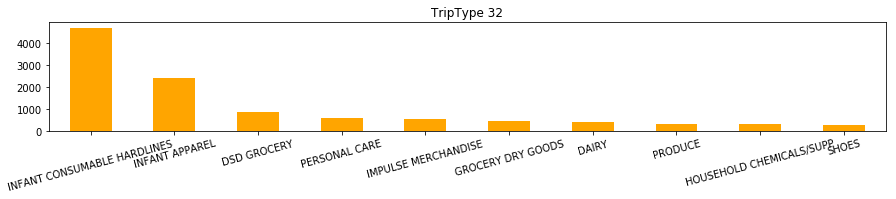

타입32는 아기용품을 구매하는 타입입니다.
 


In [20]:
triptypelist = sorted(list(train['TripType'].unique()))

type_24 = train[train.TripType == triptypelist[24]]
type_24_items = type_24[["TripType","DepartmentDescription"]]
plt.figure(figsize=(15,2))
type_24_items.DepartmentDescription.value_counts().head(10).plot(kind="bar", rot=15, title="TripType {}".format(triptypelist[24]), color="orange")
plt.show()
print(list(description.values())[24])
print(" ")

# 3-2.  `MENSWEAR` 와 `MENS WEAR`는 같은 값이므로 `MENSWEAR`로 합쳐줍니다.

In [22]:
len(train["DepartmentDescription"].unique().tolist())
train = train.replace('MENSWEAR', 'MENS WEAR')
test = test.replace('MENSWEAR', 'MENS WEAR')

# 3-3. `TripType` 별 `DepartmentDescription` 분포

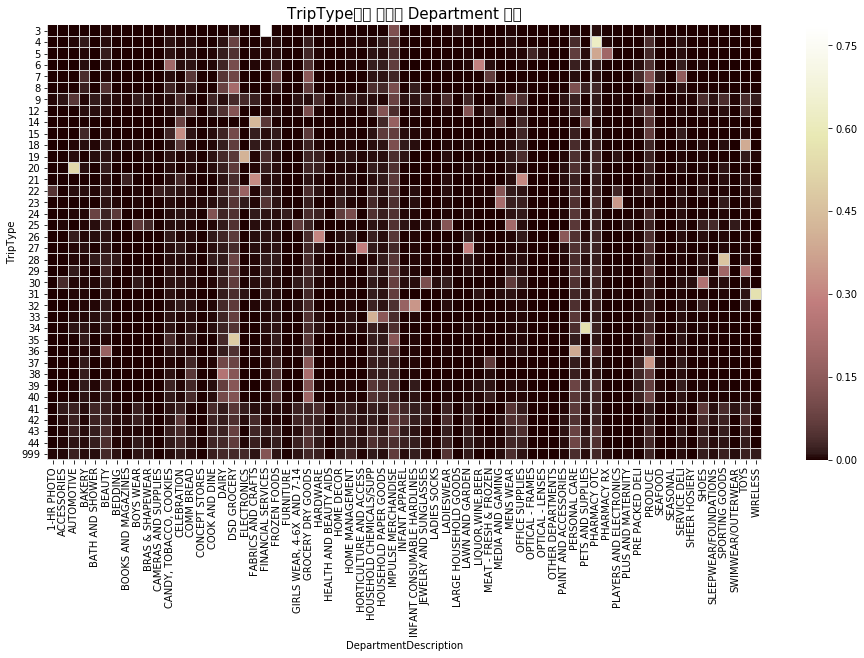

In [23]:
triptype_desc = pd.crosstab(train["TripType"], 
                        train["DepartmentDescription"], 
                        values=train["ScanCount"], 
                        aggfunc="count", 
                        normalize="index")

plt.figure(figsize=(16, 8))
sns.heatmap(triptype_desc, linecolor="lightgrey", linewidths=0.02, cmap="pink", alpha=1)
plt.title("TripType별로 살펴본 Department 분포", fontsize=15)
plt.show()

## 한 고객 특성에서 하나의 물품 종류만을 구매하는것이 아니라는걸 확인할 수 있습니다.

# 3-4. `DepartmentDescription`, `FinelineNumber`의 관계

###  `FinelineNumber`이 nan일 경우, `Upc`가 함께 nan이며 `DepartmentDescription`는 nan 혹은 `PHARMACY RX`입니다.

In [24]:
train.isna().sum()

TripType                    0
VisitNumber                 0
Weekday                     0
Upc                      4129
ScanCount                   0
DepartmentDescription    1361
FinelineNumber           4129
dtype: int64

# 3-4. pos_sum, neg_sum, return 컬럼 생성

In [25]:
train.loc[train["ScanCount"] < 0, "Return"] = 1
train.loc[train["Return"] != 1, "Return"] = 0

test.loc[test["ScanCount"] < 0, "Return"] = 1
test.loc[test["Return"] != 1, "Return"] = 0

In [26]:
train["Pos_Sum"] = train["ScanCount"]
test["Pos_Sum"] = test["ScanCount"]

train.loc[train["Pos_Sum"] < 0, "Pos_Sum"] = 0
test.loc[test["Pos_Sum"] < 0, "Pos_Sum"] = 0

In [27]:
train["Neg_Sum"] = train["ScanCount"]
test["Neg_Sum"] = test["ScanCount"]

train.loc[train["Neg_Sum"] > 0, "Neg_Sum"] = 0
test.loc[test["Neg_Sum"] > 0, "Neg_Sum"] = 0

In [28]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,Return,Pos_Sum,Neg_Sum
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,1.0,0,-1
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0,0.0,1,0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0,0.0,1,0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,0.0,2,0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,0.0,2,0


# 3-5. UPC와 관련한 특징을 만듭니다.

In [29]:
def float_to_str(obj):
    """
    Convert Upc code from float to string
    Use this function by applying lambda
    :param obj: "Upc" column of DataFrame
    :return: string converted Upc removing dot.
    """
    while obj != "nan":
        obj = str(obj).split(".")[0]
        return obj

In [30]:

def company(x):
    """
    Return company code from given Upc code.
    :param x: "Upc" column of DataFrame
    :return: company code
    """
    try:
        p = x[:6]
        if p == "000000":
            return x[-5]
        return p
    except:
        return -9999

In [31]:
train["Upc"] = train.Upc.apply(float_to_str)
test["Upc"] = test.Upc.apply(float_to_str)

train["company"] = train.Upc.apply(company) 
test["company"] = test.Upc.apply(company)

Upc에 포함되어있는 회사정보를 추출합니다.

In [32]:
train.tail()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,Return,Pos_Sum,Neg_Sum,company
647049,39,191346,Sunday,32390001778,1,PHARMACY OTC,1118.0,0.0,1,0,323900
647050,39,191346,Sunday,7874205336,1,FROZEN FOODS,1752.0,0.0,1,0,787420
647051,39,191346,Sunday,4072,1,PRODUCE,4170.0,0.0,1,0,4072
647052,8,191347,Sunday,4190007664,1,DAIRY,1512.0,0.0,1,0,419000
647053,8,191347,Sunday,3800059655,1,GROCERY DRY GOODS,3600.0,0.0,1,0,380005


In [33]:
train["Upc"] = train.Upc.apply(float_to_str)
train["company"] = train.Upc.apply(company) 
train_com = train.loc[:, ['VisitNumber', 'company']].drop_duplicates()
train_com['val'] = True
train_company = train_com.pivot('VisitNumber', 'company', 'val').fillna(False)
train_company.tail()

company,-9999,100866,101644,101645,101810,101811,101990,101991,102735,102791,...,9898,9899,993389,995000,995550,995551,996062,998000,999239,999880
VisitNumber,,,,,,,,,,,,,,,,,,,,,
191343,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
191344,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
191345,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
191346,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
191347,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [34]:

test["Upc"] = test.Upc.apply(float_to_str)
test["company"] = test.Upc.apply(company)

test_com = test.loc[:, ['VisitNumber', 'company']].drop_duplicates()
test_com['val'] = True
test_company = test_com.pivot('VisitNumber', 'company', 'val').fillna(False)


In [35]:
train_upc_fine = train[["VisitNumber", "Upc"]]
test_upc_fine = test[["VisitNumber", "Upc"]]

train_upc_fine["Upc"] = train_upc_fine.Upc.apply(float_to_str)
test_upc_fine["Upc"] = test_upc_fine.Upc.apply(float_to_str)

train_upc_fine["len_of_UPC"] = train_upc_fine["Upc"].apply(lambda x: len(x))
test_upc_fine["len_of_UPC"] = test_upc_fine["Upc"].apply(lambda x: len(x))

train_UPC = pd.get_dummies(train_upc_fine["len_of_UPC"])
train_UPC = pd.concat([train[["VisitNumber"]], train_UPC], axis=1)
train_UPC = train_UPC.groupby("VisitNumber", as_index=False).sum()

test_UPC = pd.get_dummies(test_upc_fine["len_of_UPC"])
test_UPC = pd.concat([test[["VisitNumber"]], test_UPC], axis=1)
test_UPC = test_UPC.groupby("VisitNumber", as_index=False).sum()

In [36]:
train_upc_fine.tail()

,VisitNumber,Upc,len_of_UPC
647049,191346,32390001778,11
647050,191346,7874205336,10
647051,191346,4072,4
647052,191347,4190007664,10
647053,191347,3800059655,10


In [37]:
train_UPC.tail()

,VisitNumber,3,4,5,7,8,9,10,11,12
95669,191343,0,0,0,0,0,0,2,5,0
95670,191344,0,0,0,0,0,0,3,2,0
95671,191345,0,0,0,0,0,0,11,2,0
95672,191346,0,1,0,0,0,0,15,1,0
95673,191347,0,0,0,0,0,0,2,0,0


# 3-6. Fineline을 모두 쪼개준다.

In [38]:
train_FL = pd.get_dummies(train["FinelineNumber"])
test_FL = pd.get_dummies(test["FinelineNumber"])

train_FL = pd.concat([train[["VisitNumber"]], train_FL], axis=1)
test_FL = pd.concat([test[["VisitNumber"]], test_FL], axis=1)

In [39]:
train_FL = train_FL.groupby("VisitNumber", as_index=False).sum()
test_FL = test_FL.groupby("VisitNumber", as_index=False).sum()
train_FL.tail()

,VisitNumber,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,...,9964.0,9966.0,9967.0,9970.0,9971.0,9974.0,9975.0,9991.0,9997.0,9998.0
95669,191343,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95670,191344,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95671,191345,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95672,191346,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95673,191347,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 3-7. Department Description과 관련한 특징을 만든다.

In [40]:
ttls = train["TripType"].unique().tolist()

In [41]:
train_38 = train[train['TripType'] == 38]
train_38_groupby = train_38.groupby('DepartmentDescription', as_index=False)[
    'ScanCount'].count()
train_38_groupby = train_38_groupby.sort_values('ScanCount', ascending=False)
train_39 = train[train['TripType'] == 39]
train_39_groupby = train_39.groupby('DepartmentDescription', as_index=False)[
    'ScanCount'].count()
train_39_groupby = train_39_groupby.sort_values('ScanCount', ascending=False)

Text(0.5,1,'Distribution of DD at TripType = 38')

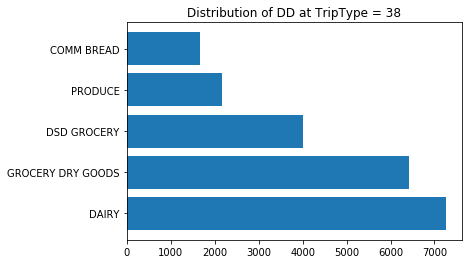

In [42]:
plt.barh((train_38_groupby['DepartmentDescription']
          [:5]), (train_38_groupby['ScanCount'][:5]))
plt.title('Distribution of DD at TripType = 38')

Text(0.5,1,'Distribution of DD at TripType = 39')

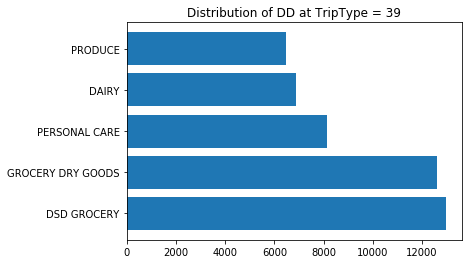

In [43]:
plt.barh((train_39_groupby['DepartmentDescription']
          [:5]), (train_39_groupby['ScanCount'][:5]))
plt.title('Distribution of DD at TripType = 39')

In [44]:

train_dd = pd.get_dummies(train["DepartmentDescription"])
test_dd = pd.get_dummies(test["DepartmentDescription"])

train_dd = pd.concat([train[["VisitNumber"]], train_dd], axis=1)
test_dd = pd.concat([test[["VisitNumber"]], test_dd], axis=1)

train_dd = train_dd.groupby("VisitNumber", as_index=False).sum()  # sum을 함
test_dd = test_dd.groupby("VisitNumber", as_index=False).sum()
train_dd.tail()

,VisitNumber,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
95669,191343,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95670,191344,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,1
95671,191345,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95672,191346,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95673,191347,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
traincolumn = list(train["DepartmentDescription"].unique())
WEARls = [x for x in traincolumn if 'WEAR' in str(x) or 'SOCKS' in str(x) or 'SHOES' in str(x)
          or 'MATERNITY' in str(x)]
FOODls = [x for x in traincolumn if 'FOOD' in str(x) or 'MEAT' in str(x) or 'DAIRY' in str(x) or 'GROCERY' in str(x)
          or 'PRODUCE' in str(x) or "BREAD" in str(x) or 'BAKERY' in str(x) or 'WINE' in str(x) or "DELI" in str(x)
          or 'COOKIE' in str(x) or 'COOK' in str(x)]
ACCls = [x for x in traincolumn if 'SUNGLASS' in str(x) or 'OPTICAL' in str(x)]
ELECls = [x for x in traincolumn if 'ELECTRONICS' in str(x) or 'CAMERAS' in str(x) or 'MEDIA' in str(x)
          or 'WIRELESS' in str(x) or 'HARDWARE' in str(x)]
COSls = [x for x in traincolumn if 'PERSONAL' in str(x) or 'BEAUTY' in str(x) or 'PHARMACY' in str(x)
         or 'BATH' in str(x)]
HOUSEls = [x for x in traincolumn if 'PAPER' in str(x) or 'HOME' in str(x) or "BEDDING" in str(x)
           or 'HOUSE' in str(x) or 'CELE' in str(x) or 'OFFICE' in str(x)]
GARDENls = [x for x in traincolumn if 'GARDEN' in str(x) or 'HORTI' in str(x)]
INFANls = [x for x in traincolumn if 'INFANT' in str(x)]
WEARls

['SHOES',
 'BOYS WEAR',
 'MENS WEAR',
 'LADIESWEAR',
 'LADIES SOCKS',
 'PLUS AND MATERNITY',
 'GIRLS WEAR, 4-6X  AND 7-14',
 'BRAS & SHAPEWEAR',
 'SLEEPWEAR/FOUNDATIONS',
 'SWIMWEAR/OUTERWEAR']

In [46]:
traindf = train.copy()
testdf = test.copy()
traindf.loc[traindf['DepartmentDescription'].isin(INFANls), "DD_big"] = "INFAN"
traindf.loc[traindf['DepartmentDescription'].isin(
    GARDENls), "DD_big"] = "GARDEN"
traindf.loc[traindf['DepartmentDescription'].isin(HOUSEls), "DD_big"] = "HOUSE"
traindf.loc[traindf['DepartmentDescription'].isin(COSls), "DD_big"] = "COS"
traindf.loc[traindf['DepartmentDescription'].isin(ELECls), "DD_big"] = "ELEC"
traindf.loc[traindf['DepartmentDescription'].isin(ACCls), "DD_big"] = "ACC"
traindf.loc[traindf['DepartmentDescription'].isin(FOODls), "DD_big"] = "FOOD"
traindf.loc[traindf['DepartmentDescription'].isin(WEARls), "DD_big"] = "WEAR"

testdf.loc[testdf['DepartmentDescription'].isin(INFANls), "DD_big"] = "INFAN"
testdf.loc[testdf['DepartmentDescription'].isin(GARDENls), "DD_big"] = "GARDEN"
testdf.loc[testdf['DepartmentDescription'].isin(HOUSEls), "DD_big"] = "HOUSE"
testdf.loc[testdf['DepartmentDescription'].isin(COSls), "DD_big"] = "COS"
testdf.loc[testdf['DepartmentDescription'].isin(ELECls), "DD_big"] = "ELEC"
testdf.loc[testdf['DepartmentDescription'].isin(ACCls), "DD_big"] = "ACC"
testdf.loc[testdf['DepartmentDescription'].isin(FOODls), "DD_big"] = "FOOD"
testdf.loc[testdf['DepartmentDescription'].isin(WEARls), "DD_big"] = "WEAR"

In [47]:
train_dd_big = pd.get_dummies(traindf["DD_big"])
test_dd_big = pd.get_dummies(testdf["DD_big"])

train_dd_big = pd.concat([traindf[["VisitNumber"]], train_dd_big], axis=1)
test_dd_big = pd.concat([testdf[["VisitNumber"]], test_dd_big], axis=1)

train_dd_big = train_dd_big.groupby("VisitNumber", as_index=False).sum()
test_dd_big = test_dd_big.groupby("VisitNumber", as_index=False).sum()
test_dd_big.tail()

,VisitNumber,ACC,COS,ELEC,FOOD,GARDEN,HOUSE,INFAN,WEAR
95669,191338,0,0,0,3,0,4,0,0
95670,191339,0,0,0,0,0,0,0,0
95671,191340,0,0,0,0,0,0,0,0
95672,191341,0,0,0,0,0,4,6,0
95673,191348,0,2,0,0,0,0,0,5


# 3-8. 요일과 관련된 더미변수를 만든다.

## TripType 14와 같이 요일이 큰 영향을 주는 경우가 있습니다.

In [48]:
weekday = {"Monday": 0,
           "Tuesday": 1,
           "Wednesday": 2,
           "Thursday": 3,
           "Friday": 4,
           "Saturday": 5,
           "Sunday": 6}
train_weekday = train[["Weekday", "VisitNumber", "TripType"]]
train_weekday["Weekday"] = train_weekday["Weekday"].apply(lambda x: weekday[x])

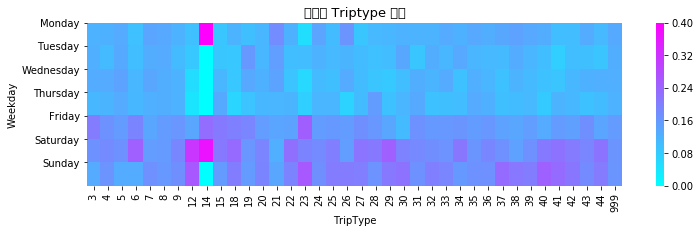

In [49]:
plt.figure(figsize=(12, 3))
sns.heatmap(data=pd.crosstab(train_weekday["Weekday"],
                             train_weekday["TripType"],
                             values=train_weekday["VisitNumber"],
                             aggfunc='count',
                             normalize="columns"), cmap="cool")
plt.yticks(range(0, 7), list(weekday.keys()), rotation="horizontal")
plt.title("요일별 Triptype 분포", fontsize=13)
plt.show()

In [50]:
train_weekday = pd.get_dummies(train["Weekday"])
test_weekday = pd.get_dummies(testdf["Weekday"])

train_weekday = pd.concat([train[["VisitNumber"]], train_weekday], axis=1)
test_weekday = pd.concat([test[["VisitNumber"]], test_weekday], axis=1)

train_weekday = train_weekday.groupby("VisitNumber", as_index=False).sum()
test_weekday = test_weekday.groupby("VisitNumber", as_index=False).sum()
train_weekday.tail()

,VisitNumber,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
95669,191343,0,0,0,7,0,0,0
95670,191344,0,0,0,5,0,0,0
95671,191345,0,0,0,13,0,0,0
95672,191346,0,0,0,17,0,0,0
95673,191347,0,0,0,2,0,0,0


# 3-7. 만들어준 데이터 프레임을 합쳐준다.

In [51]:
train_by_sum = train[["VisitNumber", "ScanCount", "Pos_Sum", "Neg_Sum"]]
test_by_sum = test[["VisitNumber", "ScanCount", "Pos_Sum", "Neg_Sum"]]

train_by_sum = train_by_sum.groupby("VisitNumber", as_index=False).sum()
test_by_sum = test_by_sum.groupby("VisitNumber", as_index=False).sum()

train = train_by_sum.merge(train_dd, on=["VisitNumber"])
train = train.merge(train_UPC, on=["VisitNumber"])
train = train.merge(train_dd_big, on=["VisitNumber"])
train = train.merge(train_FL, on=["VisitNumber"])
train = train.merge(train_weekday, on=["VisitNumber"])

test = test_by_sum.merge(test_dd, on=["VisitNumber"])
test = test.merge(test_UPC, on=["VisitNumber"])
test = test.merge(test_dd_big, on=["VisitNumber"])
test = test.merge(test_FL, on=["VisitNumber"])
test = test.merge(test_weekday, on=["VisitNumber"])

In [52]:
train = pd.merge(train, train_company, on='VisitNumber')
test = pd.merge(test, test_company, on='VisitNumber')

In [53]:
y = traindf[["TripType", 'VisitNumber']]
y.drop_duplicates(inplace=True)
y = y["TripType"]

# 3-8. test와 train 데이터의 shape을 맞춰준다.

In [54]:
not_in_train = [i for i in test.columns if i not in train.columns]
not_in_test = [i for i in train.columns if i not in test.columns]

In [55]:
total_train = train.drop(columns=not_in_test)

In [56]:
total_test = test.drop(columns=not_in_train)

# <center>4. lightgbm을 사용한 분류</center>

In [57]:
label_enc = LabelEncoder()
y_labeled = label_enc.fit_transform(y)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    total_train, y_labeled, random_state=0)

In [59]:
dtrain = lightgbm.Dataset(X_train, label=y_train)

In [60]:
dtest = lightgbm.Dataset(X_test, label=y_test)

In [61]:
num_boost_round = 1500
learning_rate = 0.02

params = {'objective': 'multiclass',
          'boosting_type': 'gbdt',
          'max_depth': -1,
          'nthread': 4,
          'metric': 'multi_logloss',
          'num_class': 38,
          'learning_rate': learning_rate,
          }

In [62]:
lightgbm_model = lightgbm.train(params=params,
                                train_set=dtrain,
                                valid_sets=[dtrain, dtest],
                                num_boost_round=num_boost_round,
                                early_stopping_rounds=10)

[1]	training's multi_logloss: 2.91313	valid_1's multi_logloss: 2.92193
Training until validation scores don't improve for 10 rounds.
[2]	training's multi_logloss: 2.80417	valid_1's multi_logloss: 2.8188
[3]	training's multi_logloss: 2.71437	valid_1's multi_logloss: 2.73311
[4]	training's multi_logloss: 2.63589	valid_1's multi_logloss: 2.65837
[5]	training's multi_logloss: 2.56564	valid_1's multi_logloss: 2.59125
[6]	training's multi_logloss: 2.50164	valid_1's multi_logloss: 2.52993
[7]	training's multi_logloss: 2.4429	valid_1's multi_logloss: 2.47358
[8]	training's multi_logloss: 2.38858	valid_1's multi_logloss: 2.42155
[9]	training's multi_logloss: 2.33781	valid_1's multi_logloss: 2.37293
[10]	training's multi_logloss: 2.29029	valid_1's multi_logloss: 2.32752
[11]	training's multi_logloss: 2.24551	valid_1's multi_logloss: 2.28469
[12]	training's multi_logloss: 2.20318	valid_1's multi_logloss: 2.24416
[13]	training's multi_logloss: 2.16306	valid_1's multi_logloss: 2.20586
[14]	training

[114]	training's multi_logloss: 0.893	valid_1's multi_logloss: 1.01662
[115]	training's multi_logloss: 0.888765	valid_1's multi_logloss: 1.01291
[116]	training's multi_logloss: 0.884577	valid_1's multi_logloss: 1.00922
[117]	training's multi_logloss: 0.880458	valid_1's multi_logloss: 1.00563
[118]	training's multi_logloss: 0.876344	valid_1's multi_logloss: 1.00202
[119]	training's multi_logloss: 0.872288	valid_1's multi_logloss: 0.998505
[120]	training's multi_logloss: 0.868343	valid_1's multi_logloss: 0.995061
[121]	training's multi_logloss: 0.864431	valid_1's multi_logloss: 0.991729
[122]	training's multi_logloss: 0.860541	valid_1's multi_logloss: 0.988362
[123]	training's multi_logloss: 0.856707	valid_1's multi_logloss: 0.98505
[124]	training's multi_logloss: 0.852914	valid_1's multi_logloss: 0.981764
[125]	training's multi_logloss: 0.849132	valid_1's multi_logloss: 0.978507
[126]	training's multi_logloss: 0.845433	valid_1's multi_logloss: 0.975384
[127]	training's multi_logloss: 0.

[224]	training's multi_logloss: 0.621161	valid_1's multi_logloss: 0.797761
[225]	training's multi_logloss: 0.619701	valid_1's multi_logloss: 0.796797
[226]	training's multi_logloss: 0.618227	valid_1's multi_logloss: 0.795757
[227]	training's multi_logloss: 0.616763	valid_1's multi_logloss: 0.794788
[228]	training's multi_logloss: 0.615338	valid_1's multi_logloss: 0.79382
[229]	training's multi_logloss: 0.613935	valid_1's multi_logloss: 0.79288
[230]	training's multi_logloss: 0.612539	valid_1's multi_logloss: 0.79197
[231]	training's multi_logloss: 0.611122	valid_1's multi_logloss: 0.790965
[232]	training's multi_logloss: 0.609737	valid_1's multi_logloss: 0.790038
[233]	training's multi_logloss: 0.608362	valid_1's multi_logloss: 0.789115
[234]	training's multi_logloss: 0.606999	valid_1's multi_logloss: 0.78822
[235]	training's multi_logloss: 0.605655	valid_1's multi_logloss: 0.787369
[236]	training's multi_logloss: 0.60431	valid_1's multi_logloss: 0.78648
[237]	training's multi_logloss:

[334]	training's multi_logloss: 0.50261	valid_1's multi_logloss: 0.726674
[335]	training's multi_logloss: 0.501803	valid_1's multi_logloss: 0.72627
[336]	training's multi_logloss: 0.500997	valid_1's multi_logloss: 0.725863
[337]	training's multi_logloss: 0.500179	valid_1's multi_logloss: 0.725433
[338]	training's multi_logloss: 0.499376	valid_1's multi_logloss: 0.725019
[339]	training's multi_logloss: 0.498586	valid_1's multi_logloss: 0.724623
[340]	training's multi_logloss: 0.497797	valid_1's multi_logloss: 0.724246
[341]	training's multi_logloss: 0.497013	valid_1's multi_logloss: 0.723855
[342]	training's multi_logloss: 0.496213	valid_1's multi_logloss: 0.723445
[343]	training's multi_logloss: 0.495392	valid_1's multi_logloss: 0.722978
[344]	training's multi_logloss: 0.49461	valid_1's multi_logloss: 0.722558
[345]	training's multi_logloss: 0.493835	valid_1's multi_logloss: 0.722184
[346]	training's multi_logloss: 0.493073	valid_1's multi_logloss: 0.721831
[347]	training's multi_loglo

[444]	training's multi_logloss: 0.429326	valid_1's multi_logloss: 0.694543
[445]	training's multi_logloss: 0.428776	valid_1's multi_logloss: 0.694339
[446]	training's multi_logloss: 0.428234	valid_1's multi_logloss: 0.694127
[447]	training's multi_logloss: 0.42768	valid_1's multi_logloss: 0.693945
[448]	training's multi_logloss: 0.427128	valid_1's multi_logloss: 0.693713
[449]	training's multi_logloss: 0.426591	valid_1's multi_logloss: 0.693528
[450]	training's multi_logloss: 0.426048	valid_1's multi_logloss: 0.693341
[451]	training's multi_logloss: 0.425495	valid_1's multi_logloss: 0.693139
[452]	training's multi_logloss: 0.424955	valid_1's multi_logloss: 0.692937
[453]	training's multi_logloss: 0.424412	valid_1's multi_logloss: 0.692694
[454]	training's multi_logloss: 0.423877	valid_1's multi_logloss: 0.692522
[455]	training's multi_logloss: 0.423326	valid_1's multi_logloss: 0.692348
[456]	training's multi_logloss: 0.422789	valid_1's multi_logloss: 0.692205
[457]	training's multi_log

[554]	training's multi_logloss: 0.376362	valid_1's multi_logloss: 0.677276
[555]	training's multi_logloss: 0.375941	valid_1's multi_logloss: 0.677161
[556]	training's multi_logloss: 0.375519	valid_1's multi_logloss: 0.677046
[557]	training's multi_logloss: 0.375091	valid_1's multi_logloss: 0.676919
[558]	training's multi_logloss: 0.37467	valid_1's multi_logloss: 0.676828
[559]	training's multi_logloss: 0.37425	valid_1's multi_logloss: 0.67671
[560]	training's multi_logloss: 0.373851	valid_1's multi_logloss: 0.676583
[561]	training's multi_logloss: 0.373445	valid_1's multi_logloss: 0.676454
[562]	training's multi_logloss: 0.373027	valid_1's multi_logloss: 0.676326
[563]	training's multi_logloss: 0.37262	valid_1's multi_logloss: 0.676197
[564]	training's multi_logloss: 0.372204	valid_1's multi_logloss: 0.676103
[565]	training's multi_logloss: 0.371785	valid_1's multi_logloss: 0.676012
[566]	training's multi_logloss: 0.371381	valid_1's multi_logloss: 0.675904
[567]	training's multi_loglos

[664]	training's multi_logloss: 0.334978	valid_1's multi_logloss: 0.667212
[665]	training's multi_logloss: 0.334654	valid_1's multi_logloss: 0.667152
[666]	training's multi_logloss: 0.334322	valid_1's multi_logloss: 0.667101
[667]	training's multi_logloss: 0.333987	valid_1's multi_logloss: 0.66702
[668]	training's multi_logloss: 0.333652	valid_1's multi_logloss: 0.666955
[669]	training's multi_logloss: 0.333329	valid_1's multi_logloss: 0.666898
[670]	training's multi_logloss: 0.332998	valid_1's multi_logloss: 0.666819
[671]	training's multi_logloss: 0.332665	valid_1's multi_logloss: 0.666743
[672]	training's multi_logloss: 0.332334	valid_1's multi_logloss: 0.66668
[673]	training's multi_logloss: 0.331997	valid_1's multi_logloss: 0.666611
[674]	training's multi_logloss: 0.331676	valid_1's multi_logloss: 0.666544
[675]	training's multi_logloss: 0.331344	valid_1's multi_logloss: 0.666465
[676]	training's multi_logloss: 0.331006	valid_1's multi_logloss: 0.666406
[677]	training's multi_logl

[774]	training's multi_logloss: 0.301435	valid_1's multi_logloss: 0.660823
[775]	training's multi_logloss: 0.301162	valid_1's multi_logloss: 0.660796
[776]	training's multi_logloss: 0.300876	valid_1's multi_logloss: 0.66077
[777]	training's multi_logloss: 0.300605	valid_1's multi_logloss: 0.660724
[778]	training's multi_logloss: 0.300324	valid_1's multi_logloss: 0.6607
[779]	training's multi_logloss: 0.300062	valid_1's multi_logloss: 0.660666
[780]	training's multi_logloss: 0.299777	valid_1's multi_logloss: 0.660628
[781]	training's multi_logloss: 0.299501	valid_1's multi_logloss: 0.66058
[782]	training's multi_logloss: 0.299225	valid_1's multi_logloss: 0.66053
[783]	training's multi_logloss: 0.298953	valid_1's multi_logloss: 0.660468
[784]	training's multi_logloss: 0.298685	valid_1's multi_logloss: 0.660437
[785]	training's multi_logloss: 0.298411	valid_1's multi_logloss: 0.66038
[786]	training's multi_logloss: 0.298147	valid_1's multi_logloss: 0.660331
[787]	training's multi_logloss:

[884]	training's multi_logloss: 0.273467	valid_1's multi_logloss: 0.657168
[885]	training's multi_logloss: 0.273228	valid_1's multi_logloss: 0.657154
[886]	training's multi_logloss: 0.272995	valid_1's multi_logloss: 0.657124
[887]	training's multi_logloss: 0.272761	valid_1's multi_logloss: 0.657112
[888]	training's multi_logloss: 0.272519	valid_1's multi_logloss: 0.657076
[889]	training's multi_logloss: 0.27229	valid_1's multi_logloss: 0.657041
[890]	training's multi_logloss: 0.272048	valid_1's multi_logloss: 0.657009
[891]	training's multi_logloss: 0.271814	valid_1's multi_logloss: 0.656984
[892]	training's multi_logloss: 0.271584	valid_1's multi_logloss: 0.656965
[893]	training's multi_logloss: 0.271347	valid_1's multi_logloss: 0.656932
[894]	training's multi_logloss: 0.271097	valid_1's multi_logloss: 0.6569
[895]	training's multi_logloss: 0.270867	valid_1's multi_logloss: 0.656875
[896]	training's multi_logloss: 0.270636	valid_1's multi_logloss: 0.656855
[897]	training's multi_loglo

[994]	training's multi_logloss: 0.249501	valid_1's multi_logloss: 0.655323
[995]	training's multi_logloss: 0.249302	valid_1's multi_logloss: 0.655307
[996]	training's multi_logloss: 0.249103	valid_1's multi_logloss: 0.655309
[997]	training's multi_logloss: 0.248904	valid_1's multi_logloss: 0.655303
[998]	training's multi_logloss: 0.248708	valid_1's multi_logloss: 0.65529
[999]	training's multi_logloss: 0.248505	valid_1's multi_logloss: 0.655263
[1000]	training's multi_logloss: 0.248307	valid_1's multi_logloss: 0.655263
[1001]	training's multi_logloss: 0.248109	valid_1's multi_logloss: 0.655265
[1002]	training's multi_logloss: 0.247907	valid_1's multi_logloss: 0.65527
[1003]	training's multi_logloss: 0.247707	valid_1's multi_logloss: 0.655267
[1004]	training's multi_logloss: 0.247512	valid_1's multi_logloss: 0.655245
[1005]	training's multi_logloss: 0.247307	valid_1's multi_logloss: 0.655242
[1006]	training's multi_logloss: 0.247106	valid_1's multi_logloss: 0.655222
[1007]	training's mu

In [63]:
y_pred_proba = lightgbm_model.predict(X_test)

In [64]:
y_pred = [np.argmax(line) for line in y_pred_proba]

In [65]:
accuracy = 100 * (1 - (sum(int(y_pred[i]) != y_test[i]
                           for i in range(len(y_test))) / float(len(y_test))))
print("TripType Accuracy = %.2f%%" % accuracy)

TripType Accuracy = 77.37%


In [66]:
print(classification_report(label_enc.inverse_transform(y_test), label_enc.inverse_transform(y_pred)))

              precision    recall  f1-score   support

           3       0.94      0.98      0.96       931
           4       0.81      0.67      0.73        87
           5       0.85      0.87      0.86      1167
           6       0.82      0.85      0.84       309
           7       0.79      0.80      0.80      1494
           8       0.88      0.90      0.89      3017
           9       0.78      0.86      0.82      2307
          12       0.64      0.37      0.47        62
          14       0.00      0.00      0.00         2
          15       0.63      0.59      0.61       237
          18       0.59      0.50      0.54       131
          19       0.73      0.64      0.68        80
          20       0.76      0.63      0.69       173
          21       0.72      0.66      0.69       158
          22       0.67      0.70      0.68       207
          23       0.75      0.63      0.68        43
          24       0.71      0.70      0.71       652
          25       0.74    

In [67]:
lightgbm_model.best_score

defaultdict(dict,
            {'training': {'multi_logloss': 0.24317159741533478},
             'valid_1': {'multi_logloss': 0.6550737519929498}})

In [68]:
import numpy as np
np.set_printoptions(threshold=np.nan)

In [139]:
# import seaborn as sn
# import pandas as pd
# import matplotlib.pyplot as plt
# array = confusion_matrix(y_labeled, y_pred)
# df_cm = pd.DataFrame(array, index = [i for i in range(38)],
#                   columns = [i for i in range(38)])
# plt.figure(figsize = (20,20))
# sn.heatmap(df_cm, annot=True)

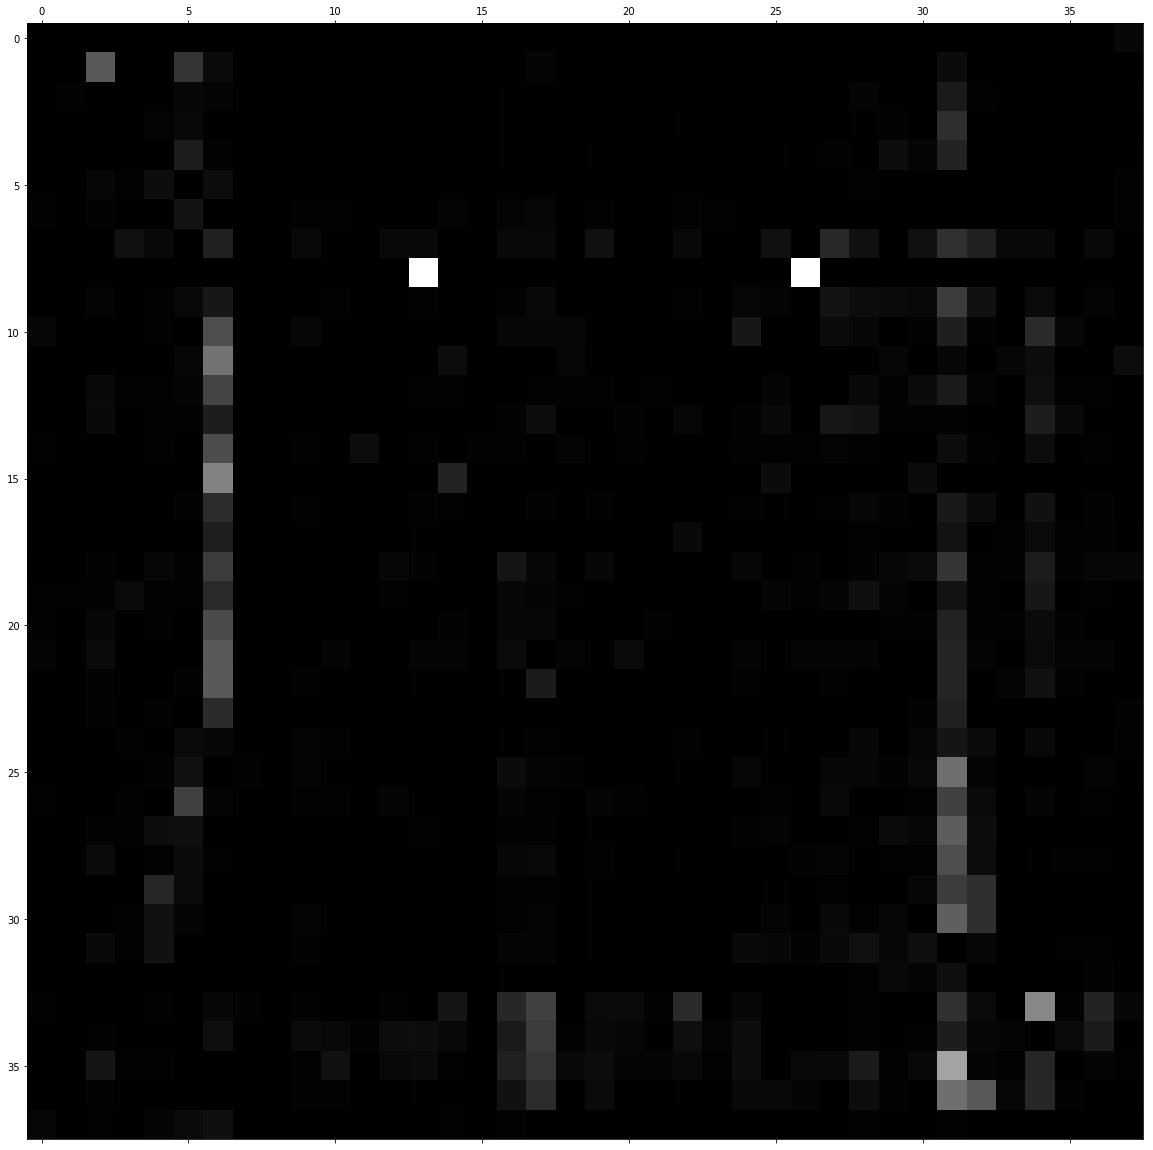

In [69]:
conf_mx = confusion_matrix(label_enc.inverse_transform(y_test), label_enc.inverse_transform(y_pred))
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.figure(figsize = (20,20))
plt.matshow(norm_conf_mx, cmap=plt.cm.gray, fignum=1)
plt.grid(False)
plt.show()


# TripType 41, 42, 43, 44를 잘 예측하지 못함을 알 수 있습니다.

# <center>5. kaggle 제출</center>

In [70]:
result = lightgbm_model.predict(total_test)
samplesub = pd.read_csv('sample_submission.csv')
subform_df_columns = samplesub.columns[1:]
result_df = pd.DataFrame(result)
result_df.columns = subform_df_columns
subform_df = pd.concat([test.reset_index()['VisitNumber'], result_df], axis=1)
subform_df.set_index('VisitNumber', inplace=True)
subform_df.tail()

,TripType_3,TripType_4,TripType_5,TripType_6,TripType_7,TripType_8,TripType_9,TripType_12,TripType_14,TripType_15,...,TripType_36,TripType_37,TripType_38,TripType_39,TripType_40,TripType_41,TripType_42,TripType_43,TripType_44,TripType_999
VisitNumber,,,,,,,,,,,,,,,,,,,,,
191338,2.450719e-06,1.327122e-06,0.000041,3.519697e-05,0.001819,0.000145,0.000056,0.000038,7.286607e-10,0.000270,...,0.000104,0.000282,0.003722,0.438481,0.001592,0.000078,0.000156,0.004475,0.000956,0.000352
191339,5.185814e-06,3.072185e-06,0.000055,1.692669e-04,0.000103,0.000933,0.001001,0.000028,9.933546e-10,0.000508,...,0.000141,0.000141,0.000262,0.006764,0.000105,0.006022,0.156682,0.010535,0.001723,0.001322
191340,7.479708e-06,4.614249e-06,0.000178,3.618827e-04,0.000231,0.704661,0.268340,0.000015,1.137685e-09,0.000669,...,0.000219,0.000121,0.000120,0.000561,0.000077,0.000043,0.000913,0.000051,0.000042,0.014382
191341,5.742425e-07,8.052773e-08,0.000003,4.433106e-07,0.000004,0.000023,0.000045,0.000012,6.501612e-11,0.000014,...,0.000044,0.000006,0.000004,0.003309,0.000088,0.000177,0.000700,0.002305,0.004575,0.000078
191348,6.951527e-07,1.339265e-07,0.000017,1.277131e-06,0.000007,0.000167,0.000047,0.000001,7.684832e-11,0.000008,...,0.000275,0.000016,0.000006,0.000195,0.000011,0.016145,0.004237,0.001042,0.000837,0.000427


In [71]:
subform_df.to_csv('lightgbm_submission_11.csv')

# 캐글 순위 182/1047

# <center>6. 모델의 한계

In [116]:
traindf = pd.read_csv("train.csv")

In [117]:
ttls = traindf["TripType"].unique().tolist()

In [118]:
train_41 = traindf[traindf['TripType'] == 41]
train_41_groupby = train_41.groupby('DepartmentDescription', as_index=False)[
    'ScanCount'].count()
train_41_groupby = train_41_groupby.sort_values('ScanCount', ascending=False)


train_42 = traindf[traindf['TripType'] == 42]
train_42_groupby = train_42.groupby('DepartmentDescription', as_index=False)[
    'ScanCount'].count()
train_42_groupby = train_42_groupby.sort_values('ScanCount', ascending=False)


train_43 = traindf[traindf['TripType'] == 43]
train_43_groupby = train_43.groupby('DepartmentDescription', as_index=False)[
    'ScanCount'].count()
train_43_groupby = train_43_groupby.sort_values('ScanCount', ascending=False)


train_44 = traindf[traindf['TripType'] == 44]
train_44_groupby = train_44.groupby('DepartmentDescription', as_index=False)[
    'ScanCount'].count()
train_44_groupby = train_44_groupby.sort_values('ScanCount', ascending=False)

Text(0.5, 1.0, 'Distribution of DD at TripType = 41')

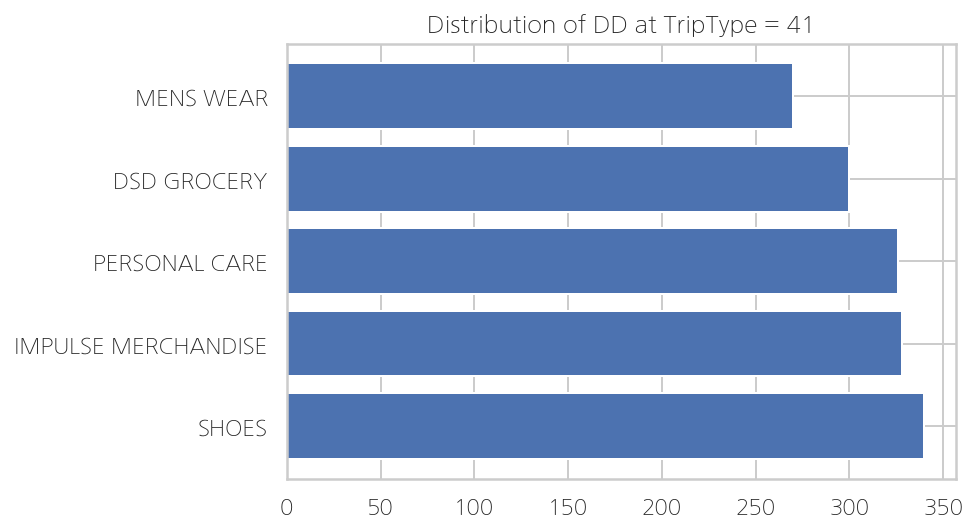

In [119]:
plt.barh((train_41_groupby['DepartmentDescription']
          [:5]), (train_41_groupby['ScanCount'][:5]))
plt.title('Distribution of DD at TripType = 41')

Text(0.5, 1.0, 'Distribution of DD at TripType = 42')

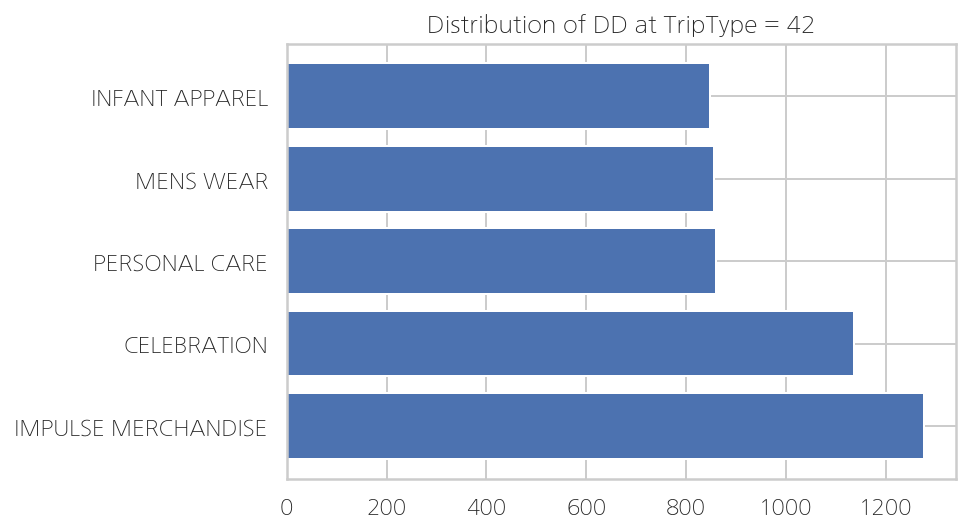

In [120]:
plt.barh((train_42_groupby['DepartmentDescription']
          [:5]), (train_42_groupby['ScanCount'][:5]))
plt.title('Distribution of DD at TripType = 42')

Text(0.5, 1.0, 'Distribution of DD at TripType = 43')

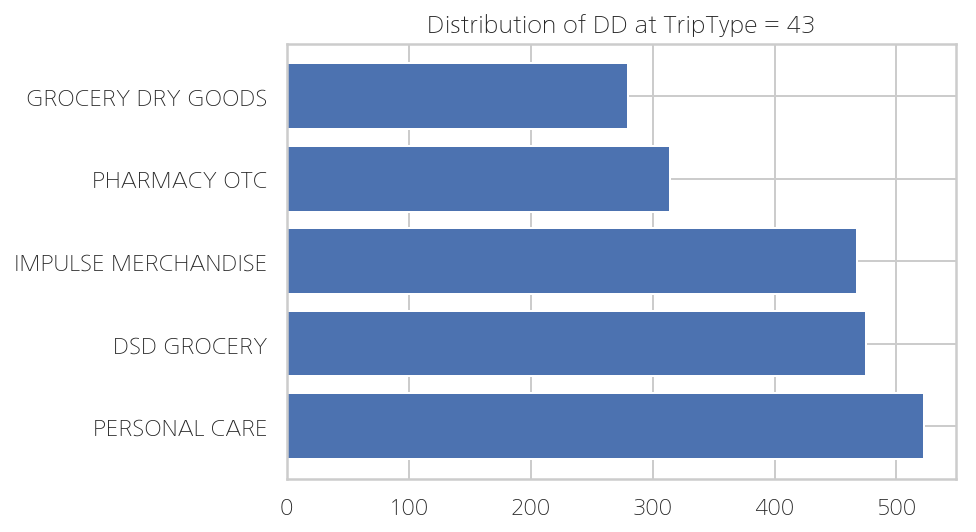

In [121]:
plt.barh((train_43_groupby['DepartmentDescription']
          [:5]), (train_43_groupby['ScanCount'][:5]))
plt.title('Distribution of DD at TripType = 43')

Text(0.5, 1.0, 'Distribution of DD at TripType = 44')

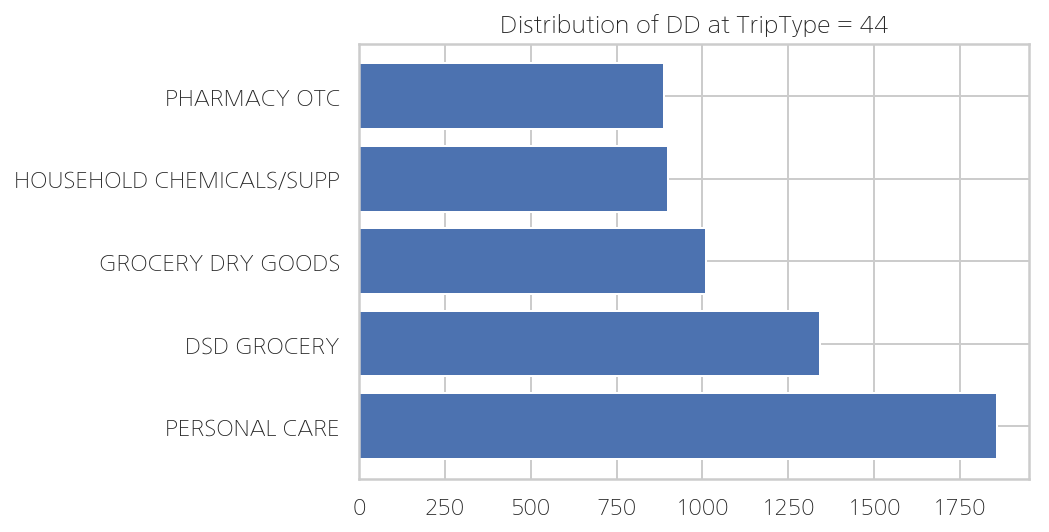

In [122]:
plt.barh((train_44_groupby['DepartmentDescription']
          [:5]), (train_44_groupby['ScanCount'][:5]))
plt.title('Distribution of DD at TripType = 44')